In [1]:
#
# Questo programma calcola il flusso di raggi cosmici attraverso un
# telescopio di contatori con normale inclinata di TG rispetto allo
# zenith (TG=0 implica telescopio verticale)
#       F Ronga novembre 1985 addatamento in Python G Mazzitelli 2021
# modifiche per telescopio per antenna RC
#
# qualche stima e dettagli nel notebook /tool/netebook_flussi.ipynb
#
import numpy as np
#  flusso cosmici in cm*2 e per ster per Eµ > 100 Mev/c per intervalli di 5 gradi 
FLUSSO=np.array([7.6693E-03, 7.6072E-03, 7.4233E-03, 7.1239E-03, 
                6.7192E-03, 6.2233E-03, 5.6530E-03, 5.0276E-03,  
                4.3678E-03, 3.6953E-03, 3.0311E-03, 2.3959E-03,
                1.8083E-03, 1.2847E-03, 8.3876E-04, 4.8100E-04, 
                2.1895E-04,  5.7297E-05, 0.])
#
#       XM,YM dimensioni contatori, ZM distanza tra i contatori
#

# attenuazione standard at LNGS
#
# h=3500
# a0=1.96e-6 #cm^2 s-1 sr -1
# h0=972 #hg/cm^2
# alpha = 1.1
# I0 = a0*((h0/h)**alpha)*np.exp(-h/h0)
# #
# where  = input('LNGS? (yes/[no])').lower()
# if where=='yes':
#     I0 = a0*((h0/h)**alpha)*np.exp(-h/h0)
# else:
#     I0 = 1
# WC contatori
# XM  = 7
# YM  = 70
XM  = 50
YM  = 50
IX  = 7 # seed
np.random.seed(IX)
print('Questo programma calcola il flusso di raggi cosmici')
print('attraverso due contatori da {:d} cm**2 a distanza variabile'.format(XM*YM))

ZM = float(input(' input distanza in cm [33] ') or "33")

NMA =   int(input('input numero di iterazioni [500]: ') or '500')
TMA = float(input('input angolo di taglio in gradi (risp verticale [0] ') or '0')
TG  = float(input('input angolo normale telescopio rispetto zenith [0](gradi)') or '0')


# TG  = TG +.0001
# Con TG=0 il programma va in errore da qualche parte

NL = np.zeros(len(FLUSSO))
NC = np.zeros(len(FLUSSO))
DISDIST = np.array([np.zeros(len(FLUSSO)),np.zeros(len(FLUSSO))]).T
DISANG  = np.array([np.zeros(len(FLUSSO)),np.zeros(len(FLUSSO))]).T

print('running.......')
TG   = np.pi/180*TG
TMA  = np.pi/180*TMA
CTG  = np.cos(TG)
STG  = np.sin(TG)

SW    = 0.
SW2   = 0.
NEVOK = 0 
NEV   = 0

while (NEVOK<NMA):
    NEV+=1
    X  = np.random.random(1)[0]*XM
    Y  = np.random.random(1)[0]*YM
    T  = np.random.random(1)[0]*np.pi
    FI = np.random.random(1)[0]*np.pi*2
    X2 = X+ZM*np.tan(T)*np.cos(FI)
    Y2 = Y+ZM*np.tan(T)*np.sin(FI)
    # print (X2, X2, XM, Y2, Y2, YM)
    if (X2 <= 0. or X2 >= XM or Y2 <= 0. or Y2 >= YM): # etrazione in accettanza
        if (NEVOK % 100)==0 : print ("Evento: accettati {:d} generati {:d}".format(NEVOK, NEV))
        DISTANZA=np.sqrt((X2-X)**2+(Y2-Y)**2+ZM**2)
# Calcola peso
        ST = np.sin(T)
        CT = np.cos(T)
        UY = ST*np.sin(FI)*STG+CT*CTG
        if (UY >= .99999): UY=  .999999
        if (UY <=-.99999): UY= -.999999
        TN = np.arccos(UY)
        if(TN >= np.pi/2): TN=np.pi-TN
        if(TN > TMA):
            NEVOK += 1
            AIN   = abs(TN)*36/np.pi
            IN    = int(AIN)
            DF    = (FLUSSO[IN+1]-FLUSSO[IN])*(AIN-IN)
    # SIN(T) effetto angolo solido,cos(T) effetto inclinazione superficie
            PESO  = (FLUSSO[IN]+DF)*abs(ST*CT)
            PESO2 = PESO**2
            SW    = SW+PESO
            SW2   = SW2+PESO2
            DISANG[IN,0]=DISANG[IN,0]+PESO
            DISANG[IN,1]=DISANG[IN,1]+PESO2
            NC[IN] = NC[IN]+1
            IN2    = int(DISTANZA/ZM/5+1)
            if(IN2>=17): IN2=17
            NL[IN2]=NL[IN2]+1
            DISDIST[IN2,0]=DISDIST[IN2,0]+PESO
            DISDIST[IN2,1]=DISDIST[IN2,1]+PESO2
            
ANORM = SW
SW    = SW/NMA
ER    = SW2
if(ER>=0.): ER=np.sqrt(ER)/NMA
print('>>>>> ------------------ ------------------ <<<<<')
print('  Valor medio funzione {:.2e} eventi accettati {:d}'.format(SW,NEVOK))
# ora moltiplica per gli intervalli il fattore /2 e' per escluder eventi dal basso
SW = SW * np.pi * 2*np.pi /2 #???
ER = ER * np.pi**2
print('  Flusso {:.2e} ± {:.2e} cm-2 s-1'.format(SW,ER))
SW=SW*XM*YM
ER=ER*XM*YM
print('  Flusso su area totale {:.2e} ± {:.2e} s-1'.format(SW,ER))
print('>>>>> ------------------ ------------------ <<<<<')
print('Percentuali per intervallo angolare: ')
for I in range(len(FLUSSO)):
    I5 = I*5
    ER = 0.
    if not (NC[I]==0):
        ER=np.sqrt(DISANG[I,1])
        ER=ER/ANORM
        VALUE=DISANG[I,0]/ANORM
        print ("{:3d} {:.1f} {:.2e} {:.2e}".format(I5,NC[I],VALUE,ER))
print('Stampa distribuzione distanze:')
# stampa distribuzione distanze in passi di 5*ZM
for I in range(len(FLUSSO)):
    I5=I*5
    ER=0.
    if not (NL[I]==0):
        ER=np.sqrt(DISDIST[I,1])
        ER=ER/ANORM
        VALUE=DISDIST[I,0]/ANORM
        print ("{:3d} {:.1f} {:.2e} {:.2e}".format(I5,NL[I],VALUE,ER))








Questo programma calcola il flusso di raggi cosmici
attraverso due contatori da 2500 cm**2 a distanza variabile


 input distanza in cm [33]  
input numero di iterazioni [500]:  
input angolo di taglio in gradi (risp verticale [0]  
input angolo normale telescopio rispetto zenith [0](gradi) 


running.......
Evento: accettati 0 generati 1
Evento: accettati 100 generati 163
Evento: accettati 200 generati 310
Evento: accettati 300 generati 464
Evento: accettati 400 generati 633
>>>>> ------------------ ------------------ <<<<<
  Valor medio funzione 9.16e-04 eventi accettati 500
  Flusso 9.04e-03 ± 5.50e-04 cm-2 s-1
  Flusso su area totale 2.26e+01 ± 1.38e+00 s-1
>>>>> ------------------ ------------------ <<<<<
Percentuali per intervallo angolare: 
  5 6.0 1.40e-02 5.77e-03
 10 6.0 2.18e-02 8.93e-03
 15 10.0 4.32e-02 1.37e-02
 20 11.0 5.59e-02 1.69e-02
 25 15.0 7.96e-02 2.06e-02
 30 17.0 8.95e-02 2.17e-02
 35 22.0 1.08e-01 2.30e-02
 40 30.0 1.32e-01 2.41e-02
 45 40.0 1.45e-01 2.30e-02
 50 38.0 1.06e-01 1.72e-02
 55 40.0 8.14e-02 1.29e-02
 60 39.0 5.54e-02 8.93e-03
 65 51.0 4.18e-02 5.93e-03
 70 37.0 1.59e-02 2.67e-03
 75 53.0 8.83e-03 1.27e-03
 80 41.0 1.73e-03 3.02e-04
 85 44.0 1.67e-04 3.44e-05
Stampa distribuzione distanze:
  5 401.0 9.97e-01 6.09e-02
 10 50.0 3.12e-03 4.9

In [2]:

import pandas as pd
def panda_from_gspreadsheet(key, sheet_name='Sheet1', header=0):
  # google spredsheet TO panda dataframe 
  # ricordarsi di abilitare lo sharing pubblico dei dati
  url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
      key=key, sheet_name=sheet_name.replace(' ', '%20'))
  return pd.read_csv(url, header=header)

def mu_fulx(E, theta):
    F = (0.14*E**-2.7)*((1/(1+1.1*E*np.cos(theta)/115))+(0.054/(1+1.1*E*np.cos(theta)/850)))
    return F # cm^2 s sr GeV

# muon flux from pagina 360 di Grieder 2001 Cosmic Ray at Earth

df = panda_from_gspreadsheet('1a9Ib-Km56cLUbcYXTognti5ngwTAdVX38_V7HhOBixk', sheet_name='all', header=0)
F2 = []
for i, E in enumerate(df['Mean [GeV/c]']):
    print('{:.2e} {:.2e} {:.2e} {:.2e}'.format(E, 
          mu_fulx(df['from [GeV/c]'][i], theta=0)-mu_fulx(df['to [GeV/c]'][i],0), 
          mu_fulx(df['Mean [GeV/c]'][i],0),
          df['Differential\nIntensity'][i]))
    F2.append([E, 
          mu_fulx(df['from [GeV/c]'][i], theta=0)-mu_fulx(df['to [GeV/c]'][i],0), 
          mu_fulx(df['Mean [GeV/c]'][i],0),
          df['Differential\nIntensity'][i]])
F2 = np.array(F2)

2.90e-01 9.62e+00 4.16e+00 3.57e-03
5.00e-01 1.16e+00 9.54e-01 3.70e-03
7.90e-01 4.37e-01 2.77e-01 3.41e-03
1.24e+00 9.75e-02 8.16e-02 2.73e-03
1.95e+00 3.66e-02 2.39e-02 1.73e-03
3.17e+00 8.78e-03 6.36e-03 7.92e-04
4.91e+00 2.26e-03 1.92e-03 4.24e-04
7.76e+00 8.39e-04 5.45e-04 1.84e-04
1.14e+01 1.40e-04 1.87e-04 1.13e-04
1.48e+01 6.88e-05 9.00e-05 6.04e-05
2.05e+01 4.06e-05 3.57e-05 2.51e-05
3.14e+01 1.51e-05 1.04e-05 8.01e-06
5.23e+01 4.18e-06 2.30e-06 1.89e-06
9.30e+01 8.05e-07 3.91e-07 3.38e-07
1.75e+02 1.26e-07 5.14e-08 5.19e-08
3.29e+02 1.36e-08 6.24e-09 7.84e-09
6.42e+02 2.01e-09 6.24e-10 6.40e-10


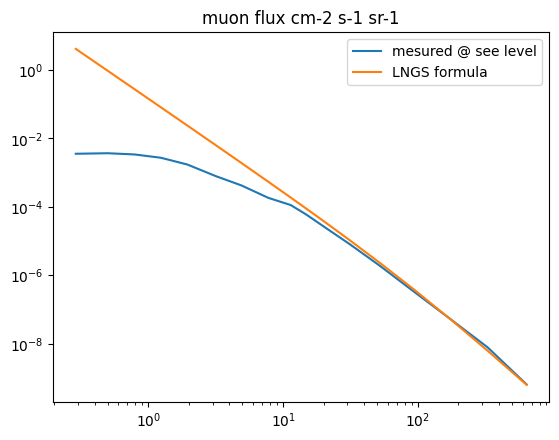

In [3]:
from matplotlib import pyplot as plt
plt.plot(F2[:, 0], F2[:, 3], label='mesured @ see level')
plt.plot(F2[:, 0], F2[:, 2], label='LNGS formula')
plt.yscale('log')
plt.xscale('log')
plt.title('muon flux cm-2 s-1 sr-1')
plt.legend()
plt.show()

In [4]:
# attenuazione del flusso undeground cm-2 s-1 sr -1
h=3200
a0=1.96e-6 #cm^2 s-1 sr -1
h0=972 #hg/cm^2
alpha = 1.1
I0 = a0*((h0/h)**alpha)*np.exp(-h/h0)
print('attanuazione dopo {:d} m.w.e. {:.2e} cm-2 s-1 sr-1'.format(h,I0))
print('flusso verticale aspettato dopo {:d} m.w.e. {:.2e} ev/m^2 s '.format(h,I0/(0.01*0.01)))

attanuazione dopo 3200 m.w.e. 1.96e-08 cm-2 s-1 sr-1
flusso verticale aspettato dopo 3200 m.w.e. 1.96e-04 ev/m^2 s 


In [5]:
# rate borexini 3.4e-4 m-2 s-1
limeVR = ((0.5*0.5)*4+(0.3*0.3)*2)*3.4e-4
limeSR = (0.5*0.5)*3.4e-4
rc = 0.5
hc = 0.5
cupidVR= (rc*np.pi**2)*hc*3.4e-4
cupidSR= (rc*np.pi**2)*3.4e-4
print('LIME:  {:.2e} ev/s rate up {:.2e} ev/day rate 4pi {:.2e} ev/day'.format(limeVR, 3600*24*limeSR, 3600*24*limeVR))
print('CUPID: {:.2e} ev/s rate up {:.2e} ev/day rate 4pi {:.2e} ev/day'.format(cupidVR, 3600*24*cupidSR, 3600*24*cupidVR))

LIME:  4.01e-04 ev/s rate up 7.34e+00 ev/day rate 4pi 3.47e+01 ev/day
CUPID: 8.39e-04 ev/s rate up 1.45e+02 ev/day rate 4pi 7.25e+01 ev/day
